<a href="https://colab.research.google.com/github/samitha278/CoreLlama/blob/main/positional_encoding_methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torch.nn as nn

import numpy as np
import math

import seaborn as sns
import matplotlib.pyplot as plt

### Binary value function

In [ ]:
def _get_binary(value):

    if value == 1 or value == 0 :
        return f"{value}"

    binary = f"{_get_binary(value//2)}{value%2}"

    return binary

bin = _get_binary(16)
print(bin)
bin_list = list(map(int,bin))
tensor = torch.tensor(bin_list)
print(tensor)

10000
tensor([1, 0, 0, 0, 0])


In [ ]:
zeros = torch.zeros((4,6))
zeros[2,6-3:] = torch.tensor([1,2,3])
zeros

tensor([[0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 2., 3.],
        [0., 0., 0., 0., 0., 0.]])

# Binary Positional Encoding

### Slow version

In [ ]:
class BinaryPE():

    def __init__(self,max_len,d_model):

        self.encoding = self._precompute_binary(max_len,d_model)


    def _get_binary(self,value):

        if value == 1 or value == 0 :
            return f"{value}"

        binary = f"{self._get_binary(value//2)}{value%2}"

        return binary


    def _precompute_binary(self,max_len,d_model):

        binary_table = torch.zeros((max_len,d_model))

        for pos in range(max_len):
            binary = list(map(int,self._get_binary(pos)))
            print(binary)

            binary_table[pos,d_model-len(binary):] = torch.tensor(binary)

        return binary_table



    def forward(self,ids):
        return self.encoding(ids)


In [ ]:
binary_pe = BinaryPE(4,6)
binary_pe.encoding

[0]
[1]
[1, 0]
[1, 1]


tensor([[0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1., 1.]])

### Optimized version

In [ ]:
class BinaryPositionalEncoding(nn.Module):

    def __init__(self,max_len,d_model):
        super().__init__()

        # to move with model to device(GPU)
        self.register_buffer('encoding', self._precompute_binary(max_len, d_model))


    def _precompute_binary(self, max_len, d_model):

        positions = torch.arange(max_len).unsqueeze(1)  # [max_len, 1]

        # bit indices (msb to lsb)
        bit_indices = torch.arange(d_model - 1, -1, -1).unsqueeze(0)  # [1, d_model]

        # right shift positions by bit_indices and mask with 1
        binary_table = (positions >> bit_indices) & 1     # braodcast tensors

        return binary_table.float()


    def forward(self,ids):
        return self.encoding[ids]

For position 5 (binary 0101):

- (5 >> 3) & 1 = (0) & 1 = 0  # MSB (bit 3)
- (5 >> 2) & 1 = (1) & 1 = 1  # bit 2
- (5 >> 1) & 1 = (2) & 1 = 0  # bit 1
- (5 >> 0) & 1 = (5) & 1 = 1  # LSB (bit 0)

Result: [0, 1, 0, 1]

In [ ]:
binary_pe = BinaryPositionalEncoding(8,12)
binary_pe(torch.arange(0,8))

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.]])

## Visualize as HeatMap

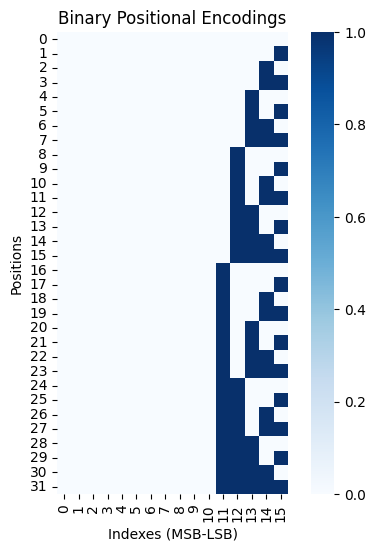

In [ ]:
max_len = 32
d_model = 16

binary_pe = BinaryPositionalEncoding(max_len,d_model)
encodings = binary_pe(torch.arange(0,max_len))


plt.figure(figsize=(6, 6))
sns.heatmap(encodings.numpy(), cmap='Blues',square=True)
plt.title(f'Binary Positional Encodings')
plt.xlabel('Indexes (MSB-LSB)')
plt.ylabel('Positions')
plt.show()

- Here binary table is MSB-LSB (natural way how we feel) # 8 = [1,0,0,0]

- When adding binary PE to Token Embedding vector there is no mathematical rule saying binary pe must be MSB-LSB or LSB-MSB.

- When we add it to token embedding use any way model will adapt.
- Both work only consistency matter

# Sinusoidal Positional Encoding

- Problem with Binary Positional Encoding is discontinuity
- Then take sin to replace binary

$$
PE_{(pos, i)} = \sin\left({pos}.\omega_i\right) \\
\omega_i = \frac{1}{10000^{i/d_{model}}} \\
PE_{(pos, i)} = \sin\left(\frac{pos}{10000^{i/d_{model}}}\right)$$


In [ ]:
class SinusoidalPE_v1(nn.Module):

    def __init__(self,max_len,d_model):
        super().__init__()

        self.d_model = d_model
        self.register_buffer('encoding', self._precompute_sinusoidal(max_len, d_model))


    def _get_sinusoidal(self,pos,i):

        return math.sin(pos/10000**(i/d_model))


    def _precompute_sinusoidal(self,max_len,d_model):

        sinusoidal_table = torch.zeros((max_len,d_model))

        # loop way : bad ~ x1000 times decrease performance
        for pos in range(max_len):
            for i in range(d_model):
                sinusoidal_table[pos,i] = self._get_sinusoidal(pos,i)

        return sinusoidal_table


    def forward(self,ids):
        return self.encoding[ids]


In [ ]:
sin_pe = SinusoidalPE_v1(4,6)
sin_pe(torch.arange(0,4))

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.8415, 0.5332, 0.3110, 0.1769, 0.0998, 0.0562],
        [0.9093, 0.9021, 0.5911, 0.3482, 0.1987, 0.1122],
        [0.1411, 0.9933, 0.8126, 0.5085, 0.2955, 0.1679]])

In [ ]:
class SinusoidalPE_v2(nn.Module):

    def __init__(self,max_len,d_model):
        super().__init__()

        self.d_model = d_model
        self.register_buffer('encoding', self._precompute_sinusoidal(max_len, d_model))



    def _precompute_sinusoidal(self,max_len,d_model):

        positions = torch.arange(max_len).unsqueeze(1)  # [max_length , 1]
        indexes = torch.arange(d_model).unsqueeze(0)    # [1,d_model]

        sinusoidal_table = torch.sin((positions/(10000**(indexes/d_model))))

        return sinusoidal_table


    def forward(self,ids):
        return self.encoding[ids]


In [ ]:
max_len = 4
d_model = 6

positions = torch.arange(max_len).unsqueeze(1)  # [max_length , 1]
indexes = torch.arange(d_model).unsqueeze(0)    # [1,d_model]

sinusoidal_table = torch.sin((positions/(10000**(indexes/d_model))))

sinusoidal_table

tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [8.4147e-01, 2.1378e-01, 4.6399e-02, 9.9998e-03, 2.1544e-03, 4.6416e-04],
        [9.0930e-01, 4.1768e-01, 9.2698e-02, 1.9999e-02, 4.3089e-03, 9.2832e-04],
        [1.4112e-01, 6.0226e-01, 1.3880e-01, 2.9995e-02, 6.4633e-03, 1.3925e-03]])

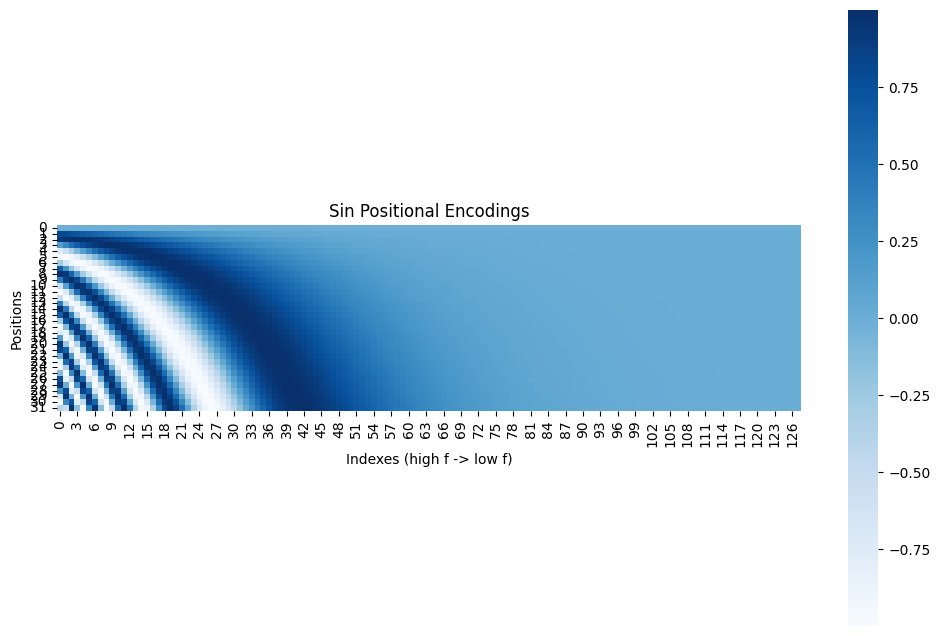

In [ ]:
max_len = 32
d_model = 128

sin_pe = SinusoidalPE_v2(max_len,d_model)
encodings = sin_pe(torch.arange(0,max_len))


plt.figure(figsize=(12, 8))
sns.heatmap(encodings.numpy(), cmap='Blues',square=True)
plt.title(f'Sin Positional Encodings')
plt.xlabel('Indexes (high f -> low f)')
plt.ylabel('Positions')
plt.show()

### Sinusoidal Positional Encoding - Intuition

### Frequency Structure

- Here sinusoidal table **MSB** → high frequencies, **LSB** → Low frequencies

- i = 0, i = 1, i = 2, ..., i = d_model
- i = 0 → high frequency
- i increases → frequency decreases

---

### Analogy: Like giving each token unique address (like barcode)

- **Low frequency dimensions** = Which continent? (changes slowly)
- **Medium frequency** = Which country?
- **High frequency** = Which street? (changes rapidly)
- **All together** = Exact location

---

### Binary Pattern (high frequencies to low frequencies)
```
Pos    1: 10000000
Pos    2: 01000000
Pos   40: 00010100
Pos   41: 10010100
Pos  200: 00010011
Pos  201: 10010011
Pos 1000: 00010111
Pos 1001: 10010111
```

---

### Sin Values
```
Pos    1: [ 0.8415,  0.5403,  0.0998,  0.9950,  0.0100,  0.9999, 0.0010, 1.0000]
Pos    2: [ 0.9093, -0.4161,  0.1987,  0.9801,  0.0200,  0.9998, 0.0020, 1.0000]
Pos   40: [ 0.7451, -0.6669, -0.7568, -0.6536,  0.3894,  0.9211, 0.0400, 0.9992]
Pos   41: [-0.1586, -0.9873, -0.8183, -0.5748,  0.3986,  0.9171, 0.0410, 0.9992]
Pos  200: [-0.8733,  0.4872,  0.9129,  0.4081,  0.9093, -0.4161, 0.1987, 0.9801]
Pos  201: [-0.0619,  0.9981,  0.9491,  0.3149,  0.9051, -0.4252, 0.1996, 0.9799]
Pos 1000: [ 0.8269,  0.5624, -0.5064,  0.8623, -0.5440, -0.8391, 0.8415, 0.5403]
Pos 1001: [ 0.9200, -0.3919, -0.4177,  0.9086, -0.5524, -0.8336, 0.8420, 0.5395]
```

---

### How Model Identifies Position Differences

- Model **identyfy near tokens** by first few dementions → **high frequincies**
- Positions **1,2 and 40,41** difference identify by looking **middlde dimentions** → **mid frequencies**
- Positioins **1,2 and 1000,1001** immediately identify by looking **last low frequncy dimentions**


** only sin yet

## Similarity between positional encodings

$$\langle PE_m, PE_n \rangle = \langle \ldots, \sin(m \cdot \omega_i), \ldots \rangle \cdot \langle \ldots, \sin(n \cdot \omega_i), \ldots \rangle$$

$$= \sum_{i=1}^{d_{model}} \sin(m \cdot \omega_i) \sin(n \cdot \omega_i)$$

$$= \sum_{i=1}^{d_{model}} \frac{1}{2} \left[\cos((m-n) \cdot \omega_i) - \cos((m+n) \cdot \omega_i)\right]$$

$$= \frac{1}{2} \sum_{i=1}^{d_{model}} \cos((m-n) \cdot \omega_i) - \frac{1}{2} \sum_{i=1}^{d_{model}} \cos((m+n) \cdot \omega_i)$$

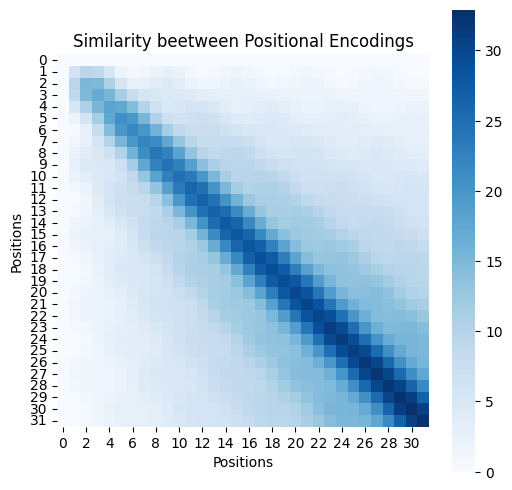

In [ ]:
similarity = torch.matmul(encodings,encodings.T)

plt.figure(figsize=(6,6))
sns.heatmap(similarity.numpy(), cmap='Blues',square=True)
plt.title(f'Similarity beetween Positional Encodings')
plt.xlabel('Positions')
plt.ylabel('Positions')
plt.show()

### Let's try to get PE(m+k,i) by only sin positional encodings

$$PE(m+k,i) = \langle \ldots, \sin(\omega_i(m+k)), \ldots \rangle$$

$$= \langle \ldots, \sin(\omega_i \cdot m + \omega_i \cdot k), \ldots \rangle$$

Using the sine addition formula: $\sin(A + B) = \sin(A)\cos(B) + \cos(A)\sin(B)$

$$= \langle \ldots, \sin(\omega_i \cdot m)\cos(\omega_i \cdot k) + \cos(\omega_i \cdot m)\sin(\omega_i \cdot k), \ldots \rangle$$

---

### Problem with only sine positional encodings:

We need $\cos(\omega_i \cdot m)$ to express $PE(m+k)$ as a linear function of $PE(m)$, but we only have $\sin(\omega_i \cdot m)$ available

**Without cosine terms:**
- Cannot express relative positions as linear transformations

**Solution:** Use **both** sine (even dimensions) and cosine (odd dimensions) so we have all the information needed for the linear transformation!

## In Attention is All you need paper proposed way
- Problem with only taking sin is sin(0)=0
- can't direclty show relative distance
- Solution : Then take sin for even i , cos for odd i

$$PE(pos,i) = \begin{cases}
\sin\left(\frac{pos}{10000^{2i/d_{model}}}\right) & \text{for even } i \\
\cos\left(\frac{pos}{10000^{2i/d_{model}}}\right) & \text{for odd } i
\end{cases}$$

- Nice representation

$$PE_{(pos, 2i)} = \sin\left(\frac{pos}{10000^{2i/d_{model}}}\right)$$

$$PE_{(pos, 2i+1)} = \cos\left(\frac{pos}{10000^{2i/d_{model}}}\right)$$

In [ ]:
class SinusoidalPE_v3(nn.Module):

    def __init__(self,max_len,d_model):
        super().__init__()

        self.register_buffer('encoding', self._precompute_sinusoidal(max_len, d_model))



    def _precompute_sinusoidal(self,max_len,d_model):
        encodings = torch.zeros((max_len,d_model))

        positions = torch.arange(max_len).unsqueeze(1)  # [max_length , 1]
        indexes = torch.arange(0,d_model,2).unsqueeze(0)    # [1,d_model//2]

        w_i = torch.pow(10000.0,(-2*indexes)/d_model)

        encodings[:,0::2] = torch.sin((positions*w_i))
        encodings[:,1::2] = torch.cos((positions*w_i))

        return encodings


    def forward(self,ids):
        return self.encoding[ids]


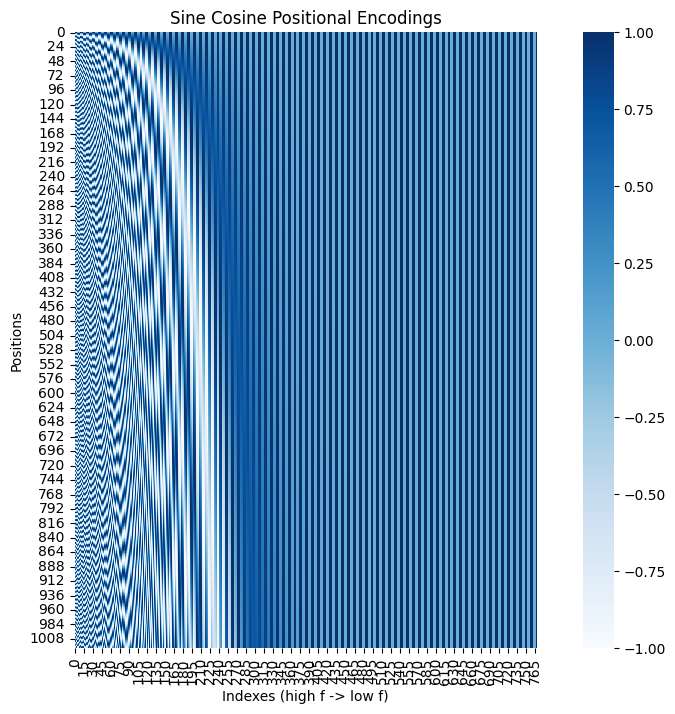

In [ ]:
max_len = 1024
d_model = 768

sin_pe = SinusoidalPE_v3(max_len,d_model)
encodings = sin_pe(torch.arange(0,max_len))


plt.figure(figsize=(12, 8))
sns.heatmap(encodings.numpy(), cmap='Blues',square=True)
plt.title(f'Sine Cosine Positional Encodings')
plt.xlabel('Indexes (high f -> low f)')
plt.ylabel('Positions')
plt.show()

### Similarity between Sinusoidal Positional Encodings

$$\langle PE_m, PE_n \rangle = \langle \ldots, \sin(m \cdot \omega_i), \cos(m \cdot \omega_i), \ldots \rangle \cdot \langle \ldots, \sin(n \cdot \omega_i), \cos(n \cdot \omega_i), \ldots \rangle$$

$$= \sum_{i=0}^{d_{model}/2 - 1} \left[\sin(m \cdot \omega_i) \sin(n \cdot \omega_i) + \cos(m \cdot \omega_i) \cos(n \cdot \omega_i)\right]$$



$$= \sum_{i=0}^{d_{model}/2 - 1} \cos((m-n) \cdot \omega_i)$$

$$=f(m-n)$$



The dot product depends **only on the relative distance** $(m-n)$ not the absolute positions

This allows the model to learn attention patterns based on relative positions.

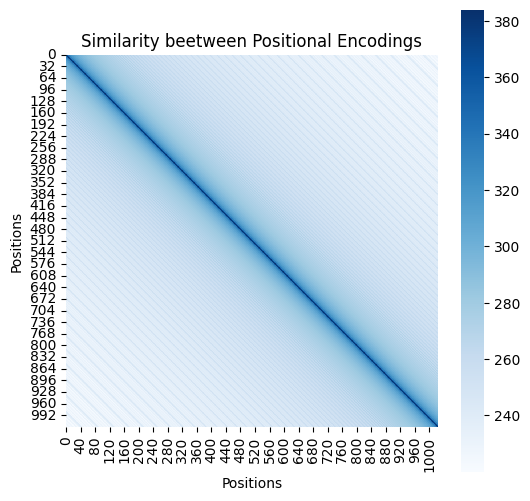

In [ ]:
similarity = torch.matmul(encodings,encodings.T)

plt.figure(figsize=(6,6))
sns.heatmap(similarity.numpy(), cmap='Blues',square=True)
plt.title(f'Similarity beetween Positional Encodings')
plt.xlabel('Positions')
plt.ylabel('Positions')
plt.show()

## Let's try to get PE(m+k,i) by sinusoidal positional encodings

$$PE(m+k,i) = \langle \ldots, \sin(\omega_i(m+k)), \cos(\omega_i(m+k)), \ldots \rangle$$

$$= \langle \ldots, \sin(\omega_i \cdot m + \omega_i \cdot k), \cos(\omega_i \cdot m + \omega_i \cdot k), \ldots \rangle$$

### both sine and cosine

Now we have **all the information** needed for linear transformations of relative positions

---

### Sinusoidal PE as 2D Rotation


### Vector Representation:

For position $m$ and dimension pair $(2i, 2i+1)$:

$$\vec{PE}_m = \begin{bmatrix} \cos(\omega_i \cdot m) \\ \sin(\omega_i \cdot m) \end{bmatrix} = \begin{bmatrix} PE(m, 2i+1) \\ PE(m, 2i) \end{bmatrix}$$

- **Angle from x-axis**: $\theta = \omega_i \cdot m$
- **x-component (cosine)**: $PE(m, 2i+1) = \cos(\theta)$
- **y-component (sine)**: $PE(m, 2i) = \sin(\theta)$
- **Magnitude**: Always 1 (unit vector)

Each position $m$ corresponds to a **unit vector** at a unique angle. As position increases, the vector rotates

---




## Deriving the Rotation Matrix from Sinusoidal PE

Starting with position $m+k$:


$$PE(m+k, 2i+1) = \cos(\omega_i \cdot m + \omega_i \cdot k)$$
$$= \cos(\omega_i \cdot m)\cos(\omega_i \cdot k) - \sin(\omega_i \cdot m)\sin(\omega_i \cdot k)$$

$$PE(m+k, 2i) = \sin(\omega_i \cdot m + \omega_i \cdot k)$$
$$= \sin(\omega_i \cdot m)\cos(\omega_i \cdot k) + \cos(\omega_i \cdot m)\sin(\omega_i \cdot k)$$

---

### Vector Form:

$$\begin{bmatrix} PE(m+k, 2i+1) \\ PE(m+k, 2i) \end{bmatrix} = \begin{bmatrix} \cos(\omega_i \cdot m)\cos(\omega_i \cdot k) - \sin(\omega_i \cdot m)\sin(\omega_i \cdot k) \\ \sin(\omega_i \cdot m)\cos(\omega_i \cdot k) + \cos(\omega_i \cdot m)\sin(\omega_i \cdot k) \end{bmatrix}$$



$$\begin{bmatrix} PE(m+k, 2i+1) \\ PE(m+k, 2i) \end{bmatrix} = \begin{bmatrix} \cos(\omega_i \cdot k) & -\sin(\omega_i \cdot k) \\ \sin(\omega_i \cdot k) & \cos(\omega_i \cdot k) \end{bmatrix} \begin{bmatrix} \cos(\omega_i \cdot m) \\ \sin(\omega_i \cdot m) \end{bmatrix}$$

$$= \begin{bmatrix} \cos(\omega_i \cdot k) & -\sin(\omega_i \cdot k) \\ \sin(\omega_i \cdot k) & \cos(\omega_i \cdot k) \end{bmatrix} \begin{bmatrix} PE(m, 2i+1) \\ PE(m, 2i) \end{bmatrix}$$

---

### Rotation Matrix:

$$R_k = \begin{bmatrix} \cos(\omega_i \cdot k) & -\sin(\omega_i \cdot k) \\ \sin(\omega_i \cdot k) & \cos(\omega_i \cdot k) \end{bmatrix}$$

This is a **2D rotation matrix** that rotates by angle $\theta = \omega_i \cdot k$ (standard counterclockwise rotation)


$$PE(m+k) = R_k \cdot PE(m)$$

**Moving from position $m$ to position $m+k$ is equivalent to rotating the positional encoding vector by a fixed angle**

This linear transformation property allows the model to easily learn relative position relationships.

# Rotary Positional Encoding - RoPE

- We take that Rotation idea to implement RoPE

In [7]:
max_len = 32
d_model = 32

pos = torch.arange(0,max_len).unsqueeze(1)

indexes = torch.arange(0,d_model//2).unsqueeze(0)
w_i = torch.pow(10000.0,(-2*indexes)/d_model)

m_w = pos * w_i


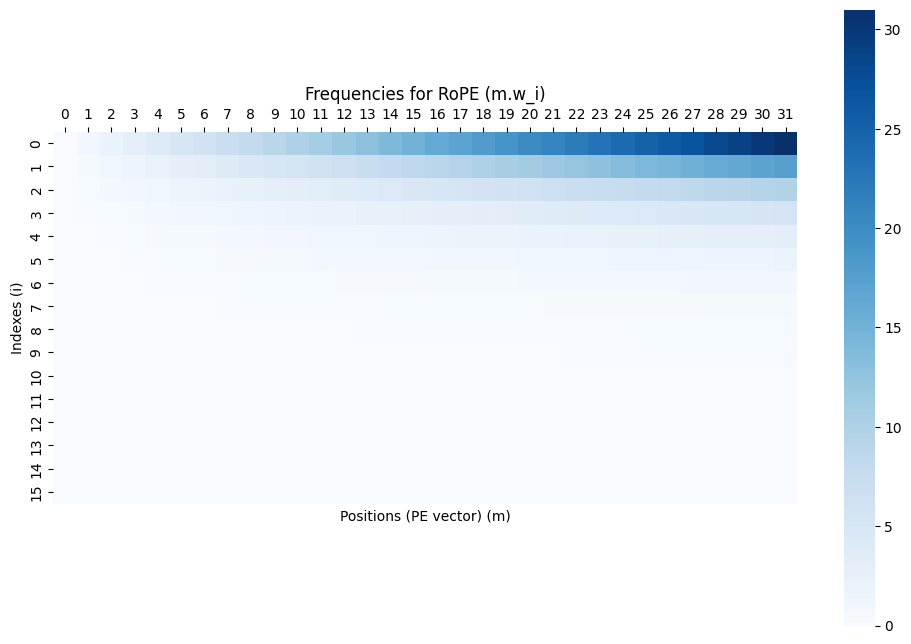

In [26]:
plt.figure(figsize=(12, 8))
sns.heatmap(m_w.T.numpy(), cmap='Blues',square=True)
plt.title(f'Frequencies for RoPE (m.w_i)')
plt.ylabel('Indexes (i)')
plt.xlabel('Positions (PE vector) (m)')
plt.show()

plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = False
plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = True


## Raw note: my own words:
- absolute sinusoidal PE property_1 : high frequences capure near positions , low frequencies capture long distance postions (easily undertand by looking binary PEs)

- Alos we gave property_2 : (relative property of sinusoidal PEs: PE(m+n,i) = R_n*PE(m,i));inner product two PEs (< PE_m, PE_n > = f(m-n)); to
RoPE by rotating token embedding(TE) by rotation matrix (R_m) now :
TE_rotated(m) = R_m * TE(m) ;
- TE_rotated(m) magnitude didn't change,only rotated each pair of dimenstions relative to it's postion contatins PE's main property_1 and also we can easily rotated TE by PE's another property_2 relative to it's position

- now when check similarity between two rotated TEs that we created relative to it's positions. Get inner product beetween them:
- < R_m TE_m, R_n TE_n > = simplify futher
- R_m.T R_n -> contains relativty of positions R_(m-n)

- will futher simplify
---


## From Sinusoidal PE to RoPE (Rotary Position Embedding)

### Property 1: Absolute Position (Frequency-based)
- **High frequencies** → capture nearby positions
- **Low frequencies** → capture long-distance positions
- *(Easy to see in binary PE patterns!)*

---

### Property 2: Relative Position (Rotation-based)

$$PE(m+k) = R_k \cdot PE(m)$$

The dot product between two positions depends only on their **relative distance**:

$$\langle PE_m, PE_n \rangle = f(m-n)$$

---

## RoPE: Rotate the Token Embeddings Instead!

### Key Idea:
Instead of **adding** PE to token embeddings, **rotate** them by position-dependent angle.

$$TE_{rotated}(m) = R_m \cdot TE(m)$$

where $R_m$ is the rotation matrix for position $m$.

---

### Why This Works:

**1. Preserves magnitude:** Only direction changes, not length
   $$||TE_{rotated}(m)|| = ||TE(m)||$$

**2. Encodes absolute position:** Each position,indexes has unique rotation angle ✓ (Property 1)

**3. Enables relative position attention:** See below ✓ (Property 2)

---

## Computing Similarity (Attention Score)

$$\langle TE_{rotated}(m), TE_{rotated}(n) \rangle = \langle R_m \cdot TE(m), R_n \cdot TE(n) \rangle$$

$$= (R_m \cdot TE(m))^T (R_n \cdot TE(n))$$

$$= TE(m)^T \cdot R_m^T \cdot R_n \cdot TE(n)$$

Since $R_m^T \cdot R_n = R_{n-m}$ (rotation matrices compose):

$$= TE(m)^T \cdot R_{n-m} \cdot TE(n)$$

---

### Key Result:

The attention score depends on:
1. Original token embeddings: $TE(m)$ and $TE(n)$
2. Their **relative position**: $R_{n-m}$

**Not** their absolute positions $m$ and $n$ separately!

---

### Summary:

**RoPE = Rotate token embeddings by their position**

**Preserves both absolute and relative position information**

**Attention naturally focuses on relative distances**

In [27]:
#############################################################################################################################

## RoPE: Rotary Position Embedding

### The Goal:

Encode relative position $(n-m)$ between query at position $m$ and key at position $n$

---

### Starting Formula:

In attention, we want: $Q(m)^T \cdot R_{n-m} \cdot K(n)$

**Problem:** Computing $R_{n-m}$ for every $(m,n)$ pair is expensive!

---

### RoPE Solution:

Rotate Q and K **separately** by their absolute positions:

$$Q_{rope}(m) = R_m \cdot Q(m)$$
$$K_{rope}(n) = R_n \cdot K(n)$$

---

### Why It Works:

$$Q_{rope}(m)^T \cdot K_{rope}(n) = (R_m Q(m))^T (R_n K(n))$$

$$= Q(m)^T R_m^T R_n K(n)$$

$$= Q(m)^T R_{n-m} K(n) \quad \checkmark$$

**Magic:** Rotation matrices compose! $R_m^T R_n = R_{n-m}$

---

### Implementation:
```python
# Step 1: Rotate Q and K by their positions
Q_rope[m] = rotate(Q[m], angle = m·ω)
K_rope[n] = rotate(K[n], angle = n·ω)

# Step 2: Compute attention normally
attention[m,n] = Q_rope[m] · K_rope[n]
```

---

### Key Insight:

**Absolute rotations** $(R_m, R_n)$ **automatically create relative attention** $(R_{n-m})$

No expensive pairwise computations needed!

In [28]:
#############################################################################################################################

## RoPE: Rotary Position Embedding

### The Rotation Matrix Structure

The full $d \times d$ rotation matrix for position $m$:

$$R_m = \begin{bmatrix}
\cos(m\theta_1) & -\sin(m\theta_1) & 0 & 0 & \cdots & 0 & 0 \\
\sin(m\theta_1) & \cos(m\theta_1) & 0 & 0 & \cdots & 0 & 0 \\
0 & 0 & \cos(m\theta_2) & -\sin(m\theta_2) & \cdots & 0 & 0 \\
0 & 0 & \sin(m\theta_2) & \cos(m\theta_2) & \cdots & 0 & 0 \\
\vdots & \vdots & \vdots & \vdots & \ddots & \vdots & \vdots \\
0 & 0 & 0 & 0 & \cdots & \cos(m\theta_{d/2}) & -\sin(m\theta_{d/2}) \\
0 & 0 & 0 & 0 & \cdots & \sin(m\theta_{d/2}) & \cos(m\theta_{d/2})
\end{bmatrix}$$

where $\theta_i = 10000^{-2i/d}$

**Block diagonal structure:** Each 2×2 block rotates a pair of dimensions independently.

---

### Efficient Computation (No Matrix Multiplication!)

Instead of computing $R_m \cdot x$, use element-wise operations:

$$R_m x = \begin{bmatrix}
x_1 \\
x_2 \\
x_3 \\
x_4 \\
\vdots \\
x_{d-1} \\
x_d
\end{bmatrix} \odot \begin{bmatrix}
\cos(m\theta_1) \\
\cos(m\theta_1) \\
\cos(m\theta_2) \\
\cos(m\theta_2) \\
\vdots \\
\cos(m\theta_{d/2}) \\
\cos(m\theta_{d/2})
\end{bmatrix} + \begin{bmatrix}
-x_2 \\
x_1 \\
-x_4 \\
x_3 \\
\vdots \\
-x_d \\
x_{d-1}
\end{bmatrix} \odot \begin{bmatrix}
\sin(m\theta_1) \\
\sin(m\theta_1) \\
\sin(m\theta_2) \\
\sin(m\theta_2) \\
\vdots \\
\sin(m\theta_{d/2}) \\
\sin(m\theta_{d/2})
\end{bmatrix}$$

where $\odot$ is element-wise multiplication.

---

### Implementation:
```python
# Precompute cos and sin
cos_m = [cos(m*θ_1), cos(m*θ_1), cos(m*θ_2), cos(m*θ_2), ...]
sin_m = [sin(m*θ_1), sin(m*θ_1), sin(m*θ_2), sin(m*θ_2), ...]

# Rotate x efficiently
x_rotated = x * cos_m + rotate_half(x) * sin_m

# where rotate_half swaps and negates pairs:
# [x₁, x₂, x₃, x₄, ...] → [-x₂, x₁, -x₄, x₃, ...]
```

---

### Key Properties:

1. **Block diagonal:** Each dimension pair rotates independently
2. **No matrix multiplication needed:** Only element-wise operations
3. **Composable:** $R_m^T R_n = R_{n-m}$ (relative position)

---

### Self-Attention with RoPE:

$$q_m^T k_n = (R_m q)^T (R_n k) = q^T R_m^T R_n k = q^T R_{n-m} k$$

Absolute rotations → Relative attention automatically!

In [82]:
# 09:30
class RoPE_v1(nn.Module):

    def __init__(self,max_len,d_model):
        super().__init__()

        self.max_len = max_len
        self.d_model = d_model

        self.sin_m,self.cos_m = self._precompute_sinusoidal_for_rope()


    def _precompute_sinusoidal_for_rope(self):

        indexes = torch.arange(0,self.d_model//2).unsqueeze(0)
        w_i = torch.pow(10000.0,(-2*indexes)/self.d_model)

        w_i_expand = torch.zeros((self.max_len,self.d_model))
        w_i_expand[:,0::2] = w_i
        w_i_expand[:,1::2] = w_i

        m = torch.arange(0,self.max_len).unsqueeze(1)

        angles = m * w_i_expand

        cos_m = torch.cos(angles)
        sin_m = torch.sin(angles)

        return sin_m , cos_m




    def forward(self,embds):
        B,T,C = embds.shape

        sin_m,cos_m = self.sin_m[:T],self.cos_m[:T]

        embds_interchanged = torch.zeros((B,T,C))
        embds_interchanged[:,:,1::2] = embds[:,:,0::2]
        embds_interchanged[:,:,0::2] = -embds[:,:,1::2]

        return embds*cos_m + embds_interchanged*sin_m




In [83]:
torch.manual_seed(278)

B,T,C = 1,4,8
q = torch.randn((B,T,C))
rope = RoPE_v1(T,C)

q_rotated = rope(q)

In [64]:
sin_m , cos_m  = rope._precompute_sinusoidal_for_rope()

print(sin_m)
print(cos_m)

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.8415, 0.8415, 0.0998, 0.0998, 0.0100, 0.0100, 0.0010, 0.0010],
        [0.9093, 0.9093, 0.1987, 0.1987, 0.0200, 0.0200, 0.0020, 0.0020],
        [0.1411, 0.1411, 0.2955, 0.2955, 0.0300, 0.0300, 0.0030, 0.0030]])
tensor([[ 1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000],
        [ 0.5403,  0.5403,  0.9950,  0.9950,  0.9999,  0.9999,  1.0000,  1.0000],
        [-0.4161, -0.4161,  0.9801,  0.9801,  0.9998,  0.9998,  1.0000,  1.0000],
        [-0.9900, -0.9900,  0.9553,  0.9553,  0.9996,  0.9996,  1.0000,  1.0000]])


In [52]:
embds = q

In [56]:
embds

tensor([[[-0.3113, -1.6257, -0.4428,  0.7869, -2.3081, -2.4534,  2.5515,
           1.5013],
         [-0.4279,  0.0149,  0.6168,  2.5252, -0.4348,  1.8983, -0.4243,
           1.1160],
         [ 1.3476, -1.8999,  0.2999,  2.0132, -0.0537,  0.0273, -0.9289,
           2.4260],
         [ 0.5965, -0.9634,  0.6497,  0.3516, -0.5396,  0.5949, -0.8981,
           1.1714]]])

In [58]:
embds_interchanged = torch.zeros((B,T,C))
embds_interchanged[:,:,1::2] = embds[:,:,0::2]
embds_interchanged[:,:,0::2] = -embds[:,:,1::2]

embds_interchanged

tensor([[[ 1.6257, -0.3113, -0.7869, -0.4428,  2.4534, -2.3081, -1.5013,
           2.5515],
         [-0.0149, -0.4279, -2.5252,  0.6168, -1.8983, -0.4348, -1.1160,
          -0.4243],
         [ 1.8999,  1.3476, -2.0132,  0.2999, -0.0273, -0.0537, -2.4260,
          -0.9289],
         [ 0.9634,  0.5965, -0.3516,  0.6497, -0.5949, -0.5396, -1.1714,
          -0.8981]]])

In [65]:
embds*cos_m

tensor([[[-0.3113, -1.6257, -0.4428,  0.7869, -2.3081, -2.4534,  2.5515,
           1.5013],
         [-0.2312,  0.0080,  0.6137,  2.5125, -0.4347,  1.8982, -0.4243,
           1.1160],
         [-0.5608,  0.7906,  0.2939,  1.9731, -0.0537,  0.0273, -0.9289,
           2.4260],
         [-0.5906,  0.9538,  0.6207,  0.3359, -0.5394,  0.5946, -0.8981,
           1.1714]]])

In [66]:
embds_interchanged*sin_m

tensor([[[ 0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,  0.0000e+00,
          -0.0000e+00, -0.0000e+00,  0.0000e+00],
         [-1.2513e-02, -3.6003e-01, -2.5209e-01,  6.1575e-02, -1.8982e-02,
          -4.3476e-03, -1.1160e-03, -4.2433e-04],
         [ 1.7276e+00,  1.2254e+00, -3.9996e-01,  5.9572e-02, -5.4543e-04,
          -1.0732e-03, -4.8520e-03, -1.8577e-03],
         [ 1.3596e-01,  8.4185e-02, -1.0390e-01,  1.9200e-01, -1.7843e-02,
          -1.6186e-02, -3.5141e-03, -2.6943e-03]]])

In [67]:
q_rot = embds*cos_m + embds_interchanged*sin_m
q_rot

tensor([[[-0.3113, -1.6257, -0.4428,  0.7869, -2.3081, -2.4534,  2.5515,
           1.5013],
         [-0.2437, -0.3520,  0.3616,  2.5741, -0.4537,  1.8938, -0.4254,
           1.1155],
         [ 1.1668,  2.0160, -0.1061,  2.0326, -0.0542,  0.0262, -0.9337,
           2.4241],
         [-0.4546,  1.0380,  0.5168,  0.5279, -0.5572,  0.5784, -0.9016,
           1.1687]]])

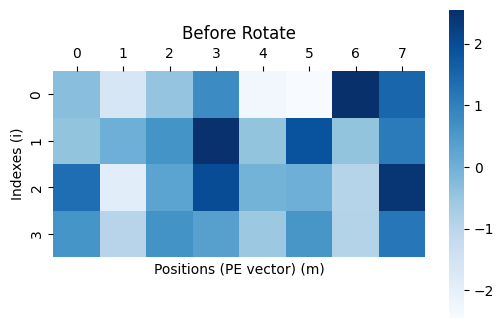

In [84]:
plt.figure(figsize=(6, 4))
sns.heatmap(q[0].numpy(), cmap='Blues',square=True)
plt.title(f'Before Rotate')
plt.ylabel('Indexes (i)')
plt.xlabel('Positions (PE vector) (m)')
plt.show()

plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = False
plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = True


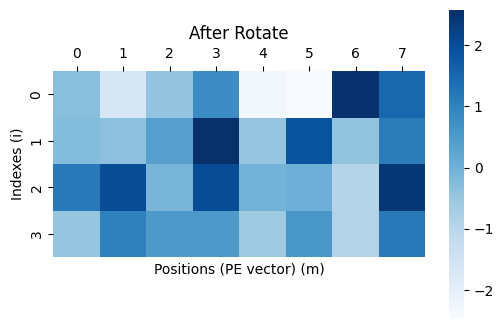

In [85]:
plt.figure(figsize=(6, 4))
sns.heatmap(q_rotated[0].numpy(), cmap='Blues',square=True)
plt.title(f'After Rotate')
plt.ylabel('Indexes (i)')
plt.xlabel('Positions (PE vector) (m)')
plt.show()

plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = False
plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = True


## Optimized version : NO unnessacry slicing, tensor inizalization and copying

In [87]:
class RoPE_v2(nn.Module):

    def __init__(self,max_len,d_model):
        super().__init__()

        self.max_len = max_len
        self.d_model = d_model

        self.sin,self.cos = self._precompute_sinusoidal_for_rope()


    def _precompute_sinusoidal_for_rope(self):

        indexes = torch.arange(0,self.d_model//2).unsqueeze(0)
        w_i = torch.pow(10000.0,(-2*indexes)/self.d_model)

        m = torch.arange(0,self.max_len).unsqueeze(1)

        angles = torch.outer(positions, w_i)   # [max_len,d_model//2]

        return torch.sin(angles),torch.cos(angles)


    def forward(self,x):

        B,T,C = x.shape

        sin,cos = self.sin[:T],self.cos[:T]

        x_pairs = x.reshape(B,T,C//2,2)

        x_even = x_pairs[...,0]     #[B,T,C//2]
        x_odd = x_pairs[...,1]

        x_even_rotated = cos*x_even-sin*x_odd
        x_odd_rotated = sin*x_even + cos*x_odd

        x_rotated = torch.stack([x_even_rotated,x_odd_rotated],dim=-1)   #B,T,C//2,2

        return x_rotated.reshape(B,T,C)



In [104]:
torch.manual_seed(278)

B,T,C = 4,512,1024
q = torch.randn((B,T,C))
rope = RoPE_v1(T,C)

q_rotated = rope(q)

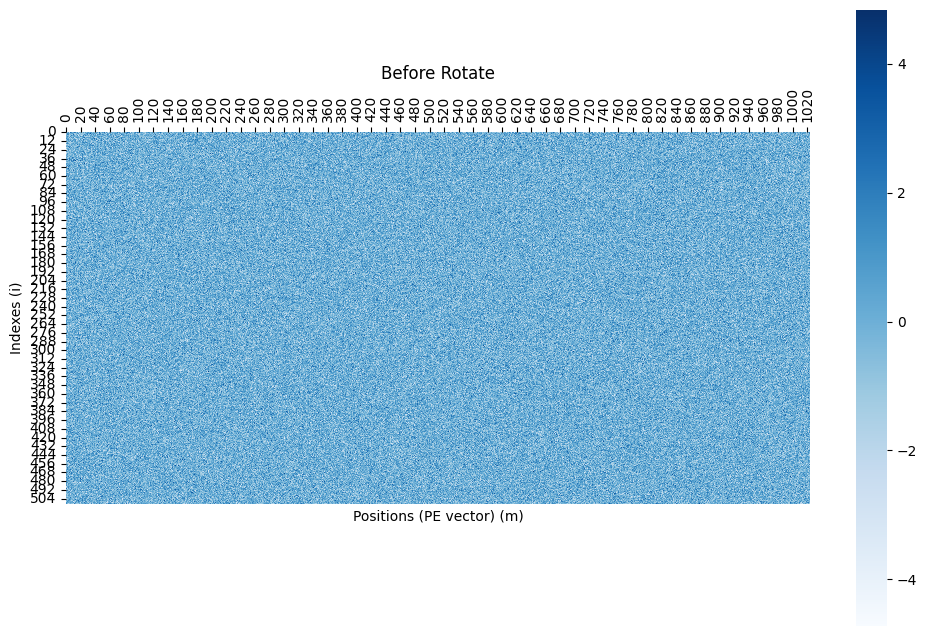

In [105]:
plt.figure(figsize=(12, 8))
sns.heatmap(q[0].numpy(), cmap='Blues',square=True)
plt.title(f'Before Rotate')
plt.ylabel('Indexes (i)')
plt.xlabel('Positions (PE vector) (m)')
plt.show()

plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = False
plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = True


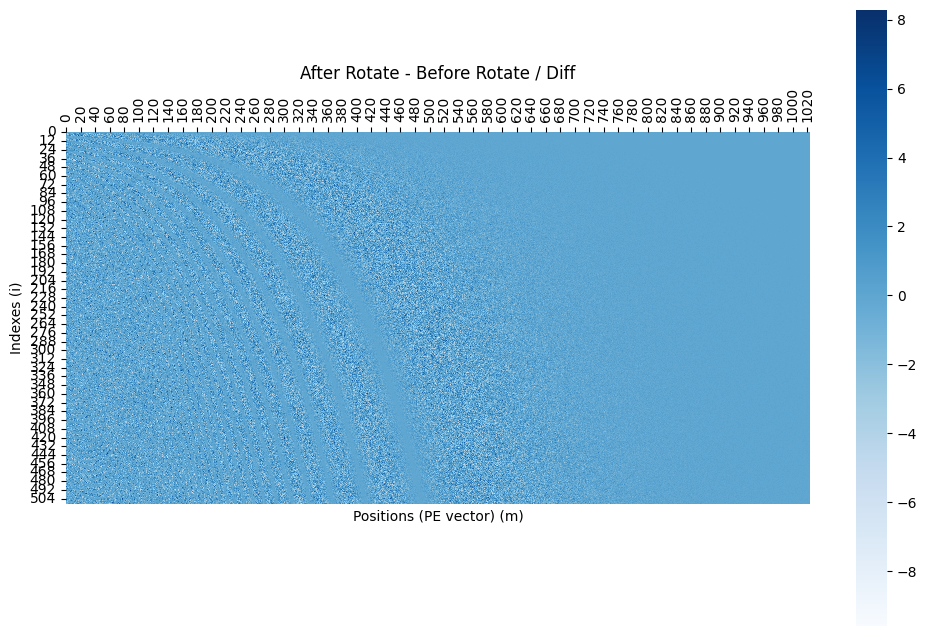

In [106]:
plt.figure(figsize=(12, 8))
sns.heatmap((q_rotated[0]-q[0]).numpy(), cmap='Blues',square=True)
plt.title(f'After Rotate - Before Rotate / Diff')
plt.ylabel('Indexes (i)')
plt.xlabel('Positions (PE vector) (m)')
plt.show()

plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = False
plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = True


- Diff between rotated vector and original vector is like Absolute Sinusoidal Positional Encodings  : Look Closely